# 估计
## 1、欧元问题
在《信息论：推理和学习算法》一书中，David MacKay提出了欧元问题：</br>
2000年1月4日，星期五，《卫报》上刊载了一个统计相关的生命：</br>
当以边缘转动比利时一欧元硬币250次后，得到的结果是正面140次反面110次。伦敦大学的教授Barry Blight认为：“如果硬币是均匀的，得到这种极端结果的可能性低于7%。”</br>
这一结果是否对“硬币偏心而非均匀”提供了证据呢？</br>

**假设**：硬币完全均匀，每次转动硬币，头朝上的概率为50%；</br>
       

## 2、二项分布(常规想法)
根据常理，硬币完全均匀的情况下，转动一次，头朝上的概率是50%；转动两次，两次头朝上的概率为25%。</br>
以上是典型的二项分布，服从</br>
$$
(^n_k)p^k(1-p)^{(n-k)}
$$


In [1]:
from scipy.stats import binom # binomial distribution
import numpy as np

n = 2 # 实验的次数
p = 0.5 # 头朝上/头朝下的概率
k = 1   # n次实验中头朝上的次数，这里表明两次转动一次头朝上，一次头朝下

binom.pmf(k, n, p)


ks = np.arange(n+1) # 分别对应头朝上次数为0，1，2

ps = binom.pmf(ks, n, p)
ps

array([0.25, 0.5 , 0.25])

In [2]:
from empiricaldist import Pmf

pmf_k = Pmf(ps, ks)
pmf_k

,probs
0,0.25
1,0.50
2,0.25


对应上面提出的欧元问题，转动250次，正面140，反面110次

125
0.050412213147309655
0.008357181724918204


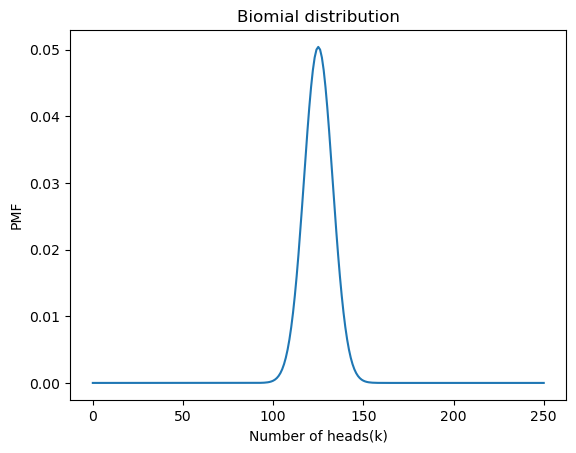

In [7]:
import matplotlib.pyplot as plt

n = 250
ks = np.arange(n+1)
ps = binom.pmf(ks, n, p)
pmf_k = Pmf(ps, ks)

pmf_k.plot()
ax = plt.gca()
ax.set(xlabel = 'Number of heads(k)', ylabel = 'PMF', title = 'Biomial distribution')

print(pmf_k.idxmax())
print(pmf_k(pmf_k.idxmax()))
print(pmf_k(140))

转动250次，概率最大的是125次正面125次反面，概率约为0.05。140次正面的概率大约0.008。我以为到这里就算完了，但是书中说伦敦大学教授所说的极端结果包含的是正面次数大于等于140，负面次数小于等于110的，需要包含这两种情况，得到的概率是6.6%。然后又说并不能证明硬币是否均匀，实在是把我搞糊涂了。
## 3、贝叶斯估计
设x是硬币为正面的概率，x的大小跟硬币的质地有关。如果硬币是均匀的，那x应该为50%；如果硬币不均匀，那x不等于50%。这就这个问题转化为贝叶斯估计参数x的问题。</br>
相当于想求得是P（x=0.5|140heads&110tails）


0.56
0.12745318058391109


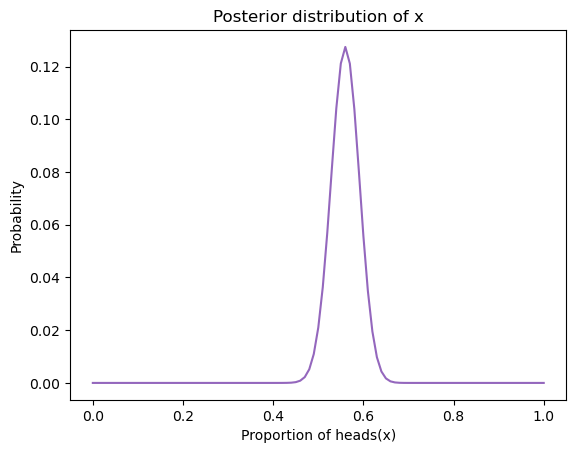

In [16]:
hypos = np.linspace(0, 1, 101) # 对应x，从0-1,间隔为0.01
prior = Pmf(1, hypos) # 先验，假设x为0-1概率是相同的，均为1

likelihood_heads = hypos # 如果x为hypos时，头朝上的概率
likelihood_tails = 1 - hypos

likelihood = {
    'H':likelihood_heads,
    'T':likelihood_tails
}

dataset = 'H' * 140 + 'T' * 110

def update_euro(pmf, dataset):
    for data in dataset:
        pmf *= likelihood[data]
        
    pmf.normalize()
    
posterior = prior.copy()
update_euro(posterior, dataset)

posterior.plot(label = '140 heads out of 250', color = 'C4')
ax = plt.gca()
ax.set(xlabel = 'Proportion of heads(x)', ylabel = 'Probability', title = 'Posterior distribution of x')

print(posterior.idxmax())
print(posterior(posterior.idxmax()))


这个结果也符合观察到的百分比就是最大似然值，140/250=56%
## 4、三角先验概率
1-3使用的先验概率都是均匀的，3中使用的先验概率都是假设x在0-1是均匀分布的。如果硬币是偏心的，那么x会偏离50%，在50%附近有较高的概率，在极端值（10%或90%）概率较低。所以我们构建先验概率的时候假设其为三角形状。

[Text(0.5, 0, 'x'), Text(0, 0.5, 'p'), Text(0.5, 1.0, 'prior')]

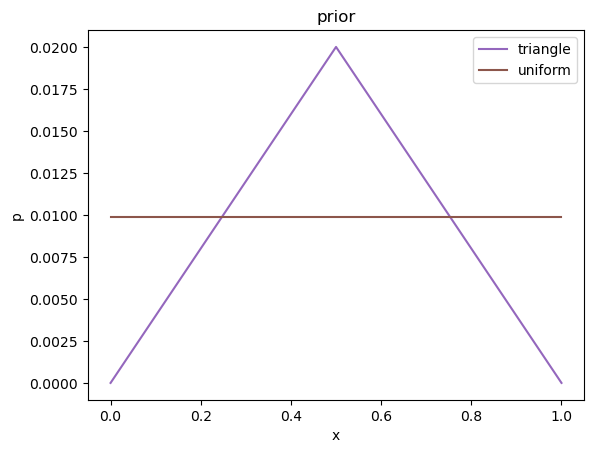

In [17]:
uniform = Pmf(1, hypos, name='uniform')
uniform.normalize()

ramp_up = np.arange(50)
ramp_down = np.arange(50, -1, -1)

a = np.append(ramp_up, ramp_down)

triangle = Pmf(a, hypos, name='triangle')
triangle.normalize()


triangle.plot(label = 'triangle', color = 'C4')
uniform.plot(label = 'uniform', color = 'C5')
ax = plt.gca()
ax.legend()
ax.set(xlabel = 'x', ylabel = 'p', title = 'prior')


<Axes: >

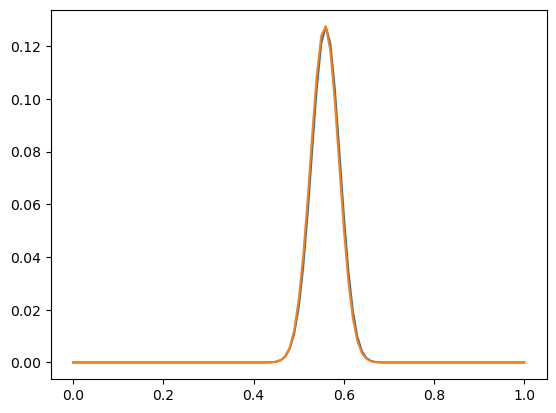

In [18]:
update_euro(uniform, dataset)
update_euro(triangle, dataset)

uniform.plot()
triangle.plot()

两个后验分布基本一样。这种情况叫做**先验湮没**：如果有足够的数据，即使在先验分布上持有不同观点，也会得到趋于收敛的后验概率